##  MNIST handwriting classification using a CNN and PyTorch

In [11]:
import torch

In [12]:
#import matplotlib as plt
import matplotlib.pyplot as plt

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
#Downloading the data set

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [15]:
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


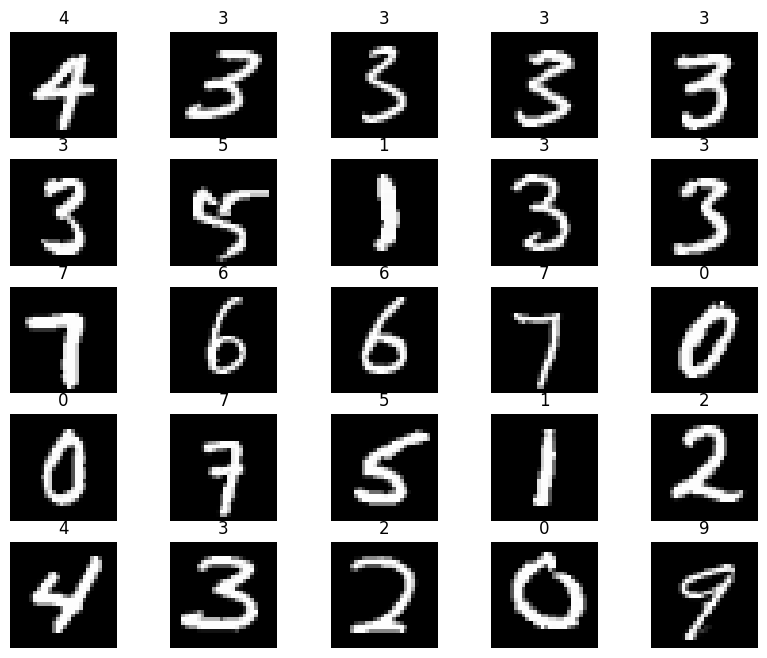

In [16]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [17]:
#Load data into PyTorch

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x167cfa6b0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x167cfa770>}

We will use 2 fully convolutional layers, Relu activation function and MaxPooling. <br> 

Conv2d: Applies a 2D convolution over an input signal composed of several input planes. <br> 

Parameters:  <br> 
in_channels (int) — Number of channels in the input image  <br> 
out_channels (int) — Number of channels produced by the convolution  <br> 
kernel_size (int or tuple) — Size of the convolving kernel <br> 
stride (int or tuple, optional) — Stride of the convolution. Default: 1 <br> 
padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0 <br> 
padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’ <br> 
dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1 <br> 
groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1 <br> 
bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

In [18]:
#Define the CNN class

import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [19]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [20]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [21]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [22]:
#Train the CNN 

from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)


Epoch [1/5], Step [100/600], Loss: 0.1225
Epoch [1/5], Step [200/600], Loss: 0.0877
Epoch [1/5], Step [300/600], Loss: 0.0286
Epoch [1/5], Step [400/600], Loss: 0.0593
Epoch [1/5], Step [500/600], Loss: 0.1007
Epoch [1/5], Step [600/600], Loss: 0.0071
Epoch [2/5], Step [100/600], Loss: 0.0823
Epoch [2/5], Step [200/600], Loss: 0.0771
Epoch [2/5], Step [300/600], Loss: 0.0298
Epoch [2/5], Step [400/600], Loss: 0.0504
Epoch [2/5], Step [500/600], Loss: 0.0508
Epoch [2/5], Step [600/600], Loss: 0.0429
Epoch [3/5], Step [100/600], Loss: 0.0460
Epoch [3/5], Step [200/600], Loss: 0.0156
Epoch [3/5], Step [300/600], Loss: 0.0220
Epoch [3/5], Step [400/600], Loss: 0.0924
Epoch [3/5], Step [500/600], Loss: 0.0203
Epoch [3/5], Step [600/600], Loss: 0.0068
Epoch [4/5], Step [100/600], Loss: 0.0256
Epoch [4/5], Step [200/600], Loss: 0.1082
Epoch [4/5], Step [300/600], Loss: 0.0330
Epoch [4/5], Step [400/600], Loss: 0.0782
Epoch [4/5], Step [500/600], Loss: 0.0282
Epoch [4/5], Step [600/600], Loss:

In [23]:
# Test the CNN
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy) 
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.96
